In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pysynphot as S
import os

%matplotlib inline
plt.rcParams["font.family"] = "monospace"
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

ALPHA_CEN_A_SURFACE_TEMP = 5790.0  # K
ALPHA_CEN_A_METALICITY = 0.2
ALPHA_CEN_A_SURFACE_GRAV = 4.0  # log(g)
ALPHA_CEN_A_MAGNITUDE = 0.01  # vega magnitude

ALPHA_CEN_B_SURFACE_TEMP = 5260.0  # K
ALPHA_CEN_B_METALICITY = 0.23
ALPHA_CEN_B_SURFACE_GRAV = 4.37  # log(g)
ALPHA_CEN_B_MAGNITUDE = 1.33  # vega magnitude

FILTER_MIN_WAVELENGTH = 530.  # nm
FILTER_MAX_WAVELENGTH = 640.  # nm



/opt/anaconda3/lib/python3.12/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/opt/anaconda3/lib/python3.12/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [3]:
A_sp = S.Icat(
    "phoenix",
    ALPHA_CEN_A_SURFACE_TEMP,
    ALPHA_CEN_A_METALICITY,
    ALPHA_CEN_A_SURFACE_GRAV,
)

B_sp = S.Icat(
    "phoenix",
    ALPHA_CEN_B_SURFACE_TEMP,
    ALPHA_CEN_B_METALICITY,
    ALPHA_CEN_B_SURFACE_GRAV,
)

# Renormalising to respective magnitudes
VBand = S.ObsBandpass('v')
A_sp = A_sp.renorm(RNval=ALPHA_CEN_A_MAGNITUDE, RNUnits='vegamag', band=VBand)
B_sp = B_sp.renorm(RNval=ALPHA_CEN_B_MAGNITUDE, RNUnits='vegamag', band=VBand)

# Converting units
A_sp.convert('nm')
A_sp.convert('Photlam')
B_sp.convert('nm')
B_sp.convert('Photlam')


sum_sp = A_sp.flux + B_sp.flux

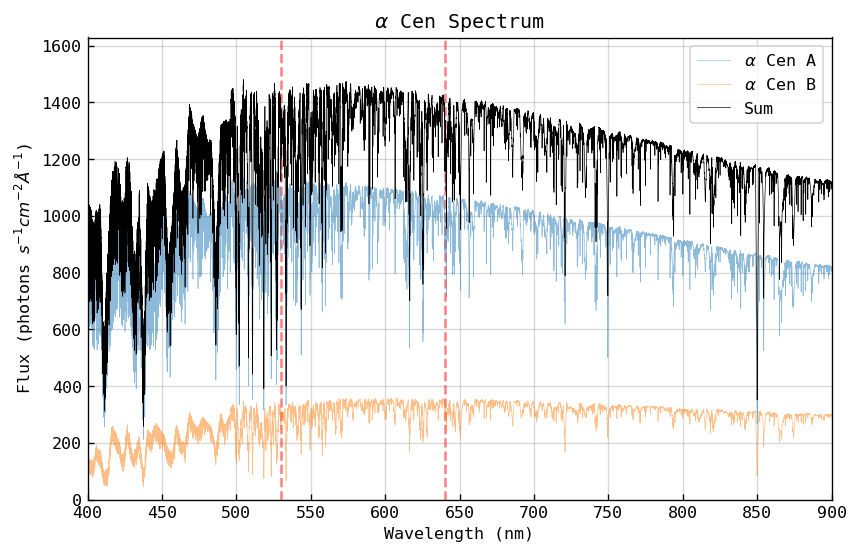

In [4]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot([FILTER_MIN_WAVELENGTH,FILTER_MIN_WAVELENGTH],[0,sum_sp.max()*1.1], 'r--', alpha=.5)
ax.plot([FILTER_MAX_WAVELENGTH,FILTER_MAX_WAVELENGTH],[0,sum_sp.max()*1.1], 'r--', alpha=.5)
ax.plot(A_sp.wave, A_sp.flux, label =r'$\alpha$ Cen A', alpha=.5, lw=.4)
ax.plot(B_sp.wave, B_sp.flux, label =r'$\alpha$ Cen B', alpha=.5, lw=.4)
ax.plot(A_sp.wave, sum_sp, label ='Sum', c ='k', lw=.4)
ax.set(title =r'$\alpha$ Cen Spectrum',
        xlabel = f'Wavelength ({A_sp.waveunits})',
        ylabel = r'Flux (photons $s^{-1}cm^{-2}\AA^{-1}$)',
        xlim = (400, 900),
        xticks = np.linspace(400, 900, 11),
        ylim = (0, sum_sp.max() * 1.1),
        )
ax.grid(alpha = 0.5)
ax.legend()
plt.show()

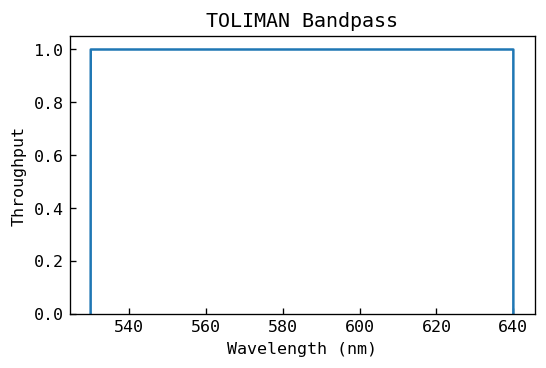

In [5]:
# converting to angstrom for pysynphot
centre = 10 * (FILTER_MIN_WAVELENGTH + FILTER_MAX_WAVELENGTH)/2
bandwidth = 10 * (FILTER_MAX_WAVELENGTH - FILTER_MIN_WAVELENGTH)

bandpass = S.Box(centre, bandwidth) # add efficiency factor here
bandpass.convert('nm')

plt.figure(figsize=(5,3))
plt.plot(bandpass.wave, bandpass.throughput)
plt.ylim(0, 1.05)
plt.xlabel(f'Wavelength ({bandpass.waveunits})')
plt.ylabel('Throughput')
plt.title('TOLIMAN Bandpass')
plt.show()


In [6]:
A_obs = S.Observation(A_sp, bandpass)
B_obs = S.Observation(B_sp, bandpass)
sum_obs = A_obs.flux + B_obs.flux

(<pysynphot.spectrum.Box object at 0x126543740>) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(<pysynphot.spectrum.Box object at 0x126543740>) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


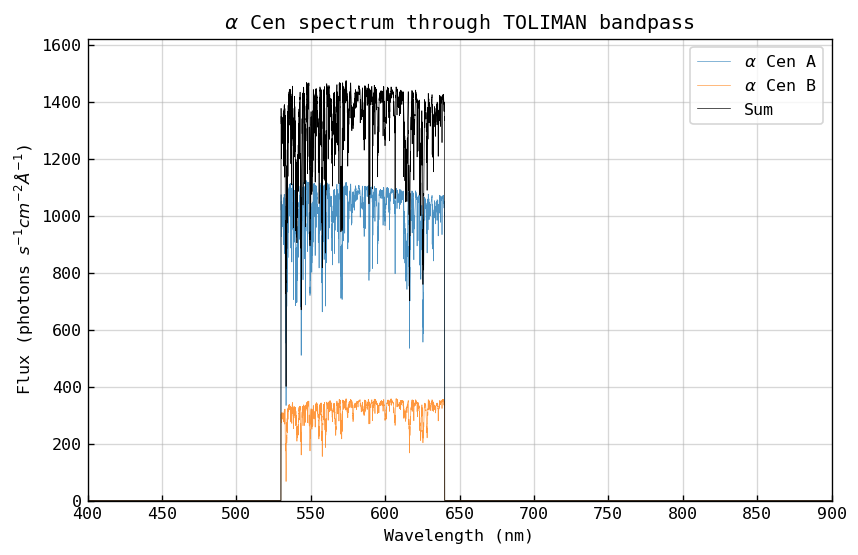

In [7]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(A_obs.wave, A_obs.flux, label=r'$\alpha$ Cen A', alpha=.8, lw=.4)
ax.plot(B_obs.wave, B_obs.flux, label=r'$\alpha$ Cen B', alpha=.8, lw=.4)
ax.plot(A_obs.wave, sum_obs, label='Sum', c='k', lw=.4)
ax.set(title = r'$\alpha$ Cen spectrum through TOLIMAN bandpass',
        xlabel = f'Wavelength ({A_sp.waveunits})',
        ylabel = r'Flux (photons $s^{-1}cm^{-2}\AA^{-1}$)',
        xlim = (400, 900),
        xticks = np.linspace(400, 900, 11),
        ylim = (0, sum_obs.max() * 1.1),
        )
ax.grid(alpha = 0.5)
ax.legend()
plt.show()

In [8]:
primary = np.pi*(12.5**2 - 3.2**2)

S.setref(graphtable='mtab/57g1733im_tmg.fits',
         comptable='mtab/6cf2109gm_tmc.fits',
         thermtable='mtab/3241637sm_tmt.fits',
         area=primary, # not sure that this actually doe
         )

print(f'TOLIMAN Primary Area: {primary:.2f} square cm.')

TOLIMAN Primary Area: 458.70 square cm.


In [9]:
countrate = A_obs.integrate() + B_obs.integrate()
print(f'AlfCen A: {A_obs.integrate():.3e} photons/s/cm/cm; {A_obs.integrate()*primary:.3e} photons/s')
print(f'AlfCen B: {B_obs.integrate():.3e} photons/s/cm/cm; {B_obs.integrate()*primary:.3e} photons/s')
print(f'Total count rate: {countrate:.3e} photons/s/cm/cm; {countrate*primary:.3e} photons/s')
print(f'Total count rate (LOG FLUX): {np.log10(countrate*primary):.3f} photons/s')
count_rate_10s = countrate *primary* 10
print(f'Total count rate for 10 seconds  (LOG FLUX): {np.log10(count_rate_10s):.3e} photons')
count_rate_100s = countrate *primary* 100
print(f'Total count rate for 100 seconds  (LOG FLUX): {np.log10(count_rate_100s):.3e} photons')
count_rate_1000s = countrate *primary* 1000
print(f'Total count rate for 1000 seconds  (LOG FLUX): {np.log10(count_rate_1000s):.3e} photons')
count_rate_10000s = countrate *primary* 10000
print(f'Total count rate for 10000 seconds  (LOG FLUX): {np.log10(count_rate_10000s):.3e} photons')

contrast = A_obs.integrate() / B_obs.integrate()
print(f'Contrast (AlfCen A / AlfCen B): {contrast:.3f}')

AlfCen A: 1.128e+05 photons/s/cm/cm; 5.176e+07 photons/s
AlfCen B: 3.524e+04 photons/s/cm/cm; 1.616e+07 photons/s
Total count rate: 1.481e+05 photons/s/cm/cm; 6.793e+07 photons/s
Total count rate (LOG FLUX): 7.832 photons/s
Total count rate for 10 seconds  (LOG FLUX): 8.832e+00 photons
Total count rate for 100 seconds  (LOG FLUX): 9.832e+00 photons
Total count rate for 1000 seconds  (LOG FLUX): 1.083e+01 photons
Total count rate for 10000 seconds  (LOG FLUX): 1.183e+01 photons
Contrast (AlfCen A / AlfCen B): 3.203
